In [24]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [26]:
!cp /content/drive/MyDrive/Kaggle_credentials/kaggle.json ~/.kaggle/kaggle.json

In [27]:
! chmod 600 ~/.kaggle/kaggle.json

In [28]:
# ! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

In [29]:
# ! unzip /content/walmart-recruiting-store-sales-forecasting.zip
# ! unzip /content/train.csv.zip
# ! unzip /content/test.csv.zip
# ! unzip /content/features.csv.zip
# ! unzip /content/sampleSubmission.csv.zip

In [30]:
# !pip install wandb -qU

# # Clean up all related packages
# !pip uninstall -y pmdarima numpy scipy statsmodels

# # Reinstall pinned, compatible versions
# !pip install numpy==1.24.4 scipy==1.10.1 statsmodels==0.13.5 pmdarima==2.0.3

In [31]:
import wandb
import random
import math
import pandas as pd
import numpy as np
import warnings
from datetime import datetime


In [32]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [33]:
import pandas as pd
import numpy as np
import wandb
import pickle
import joblib
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Initialize WandB
wandb.init(project="walmart-sales-forecasting", name="Prophet_Experiment")

# Load data
print("Loading data...")
train_df = pd.read_csv("/content/train.csv")
features_df = pd.read_csv("/content/features.csv")
stores_df = pd.read_csv("/content/stores.csv")
test_df = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sampleSubmission.csv")

print("Data loaded successfully!")
print(f"Train shape: {train_df.shape}")
print(f"Features shape: {features_df.shape}")
print(f"Stores shape: {stores_df.shape}")
print(f"Test shape: {test_df.shape}")

# Log dataset info to WandB
wandb.log({
    "train_samples": len(train_df),
    "test_samples": len(test_df),
    "n_stores": train_df['Store'].nunique(),
    "n_departments": train_df['Dept'].nunique()
})

missing_values_test,▁▁
missing_values_train,▁▁
n_departments,▁
n_stores,▁
test_samples,▁
train_samples,▁
missing_values_test,0
missing_values_train,0
n_departments,81
n_stores,45
test_date_range,2012-11-02 00:00:00 ...


Loading data...
Data loaded successfully!
Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)
Test shape: (115064, 4)


In [34]:
# Block 2: Ultra-Simple SARIMA Training (Guaranteed to Work)
class WalmartDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.store_encodings = {}
        self.dept_encodings = {}

    def fit(self, X, y=None):
        return self

    def transform(self, X, is_train=True):
        # Make a copy to avoid modifying original data
        df = X.copy()

        # Convert Date to datetime first
        df['Date'] = pd.to_datetime(df['Date'])

        # Also convert Date in features_df and stores_df to datetime
        features_df_copy = features_df.copy()
        features_df_copy['Date'] = pd.to_datetime(features_df_copy['Date'])

        # Merge with features data (matching on Store and Date)
        df = df.merge(features_df_copy, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))

        # Merge with stores data (only matching on Store, no Date column in stores)
        df = df.merge(stores_df, on='Store', how='left')

        # Handle missing values in numeric columns
        numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())

        # Fill markdown columns with 0 (these are promotional markdowns)
        markdown_cols = [f'MarkDown{i}' for i in range(1, 6)]
        for col in markdown_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)

        # Handle IsHoliday column - take the one from main data, fill missing with features data
        if 'IsHoliday_feat' in df.columns:
            df['IsHoliday'] = df['IsHoliday'].fillna(df['IsHoliday_feat'])
            df = df.drop('IsHoliday_feat', axis=1)

        # Create time-based features
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Week'] = df['Date'].dt.isocalendar().week
        df['DayOfYear'] = df['Date'].dt.dayofyear
        df['Quarter'] = df['Date'].dt.quarter

        # Create holiday features
        df['IsHoliday'] = df['IsHoliday'].astype(int)

        # Create store type features
        if 'Type' in df.columns:
            df['Type_A'] = (df['Type'] == 'A').astype(int)
            df['Type_B'] = (df['Type'] == 'B').astype(int)
            df['Type_C'] = (df['Type'] == 'C').astype(int)

        # Handle Size column
        if 'Size' in df.columns:
            df['Size'] = df['Size'].fillna(df['Size'].median())

        return df

# Initialize preprocessor
preprocessor = WalmartDataPreprocessor()

# Preprocess data
print("Preprocessing data...")
try:
    processed_train = preprocessor.transform(train_df, is_train=True)
    processed_test = preprocessor.transform(test_df, is_train=False)

    print("Data preprocessing completed!")
    print(f"Processed train shape: {processed_train.shape}")
    print(f"Processed test shape: {processed_test.shape}")

    # Check for any remaining missing values
    print(f"Missing values in train: {processed_train.isnull().sum().sum()}")
    print(f"Missing values in test: {processed_test.isnull().sum().sum()}")

    # Display column info
    print(f"Train columns: {list(processed_train.columns)}")
    print(f"Test columns: {list(processed_test.columns)}")

except Exception as e:
    print(f"Error in preprocessing: {e}")

    # Debug: Check data types
    print("\nDebugging - Data types:")
    print("Train Date type:", train_df['Date'].dtype)
    print("Features Date type:", features_df['Date'].dtype)
    print("Stores columns:", stores_df.columns.tolist())

    # Show sample data
    print("\nSample data:")
    print("Train sample:")
    print(train_df.head())
    print("\nFeatures sample:")
    print(features_df.head())
    print("\nStores sample:")
    print(stores_df.head())

# Log preprocessing info to WandB
if 'processed_train' in locals() and 'processed_test' in locals():
    wandb.log({
        "processed_train_shape": processed_train.shape,
        "processed_test_shape": processed_test.shape,
        "missing_values_train": processed_train.isnull().sum().sum(),
        "missing_values_test": processed_test.isnull().sum().sum(),
        "train_date_range": f"{processed_train['Date'].min()} to {processed_train['Date'].max()}",
        "test_date_range": f"{processed_test['Date'].min()} to {processed_test['Date'].max()}"
    })

# Initialize preprocessor
preprocessor = WalmartDataPreprocessor()

# Preprocess data
print("Preprocessing data...")
processed_train = preprocessor.transform(train_df, is_train=True)
processed_test = preprocessor.transform(test_df, is_train=False)

print("Data preprocessing completed!")
print(f"Processed train shape: {processed_train.shape}")
print(f"Processed test shape: {processed_test.shape}")

# Log preprocessing info
wandb.log({
    "processed_train_shape": processed_train.shape,
    "processed_test_shape": processed_test.shape,
    "missing_values_train": processed_train.isnull().sum().sum(),
    "missing_values_test": processed_test.isnull().sum().sum()
})

Preprocessing data...
Data preprocessing completed!
Processed train shape: (421570, 24)
Processed test shape: (115064, 23)
Missing values in train: 0
Missing values in test: 0
Train columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Year', 'Month', 'Week', 'DayOfYear', 'Quarter', 'Type_A', 'Type_B', 'Type_C']
Test columns: ['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Year', 'Month', 'Week', 'DayOfYear', 'Quarter', 'Type_A', 'Type_B', 'Type_C']
Preprocessing data...
Data preprocessing completed!
Processed train shape: (421570, 24)
Processed test shape: (115064, 23)


In [35]:
# Block 3: Robust Department-Level SARIMA (Will Actually Work)
import logging
import sys
from contextlib import redirect_stdout, redirect_stderr
import os

# Suppress Prophet's verbose output
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Also suppress other verbose loggers
logging.getLogger().setLevel(logging.WARNING)

# Suppress stdout from Prophet
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

class ProphetModel(BaseEstimator):
    def __init__(self,
                 changepoint_prior_scale=0.05,
                 seasonality_prior_scale=10.0,
                 holidays_prior_scale=10.0,
                 seasonality_mode='additive',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=False):

        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.seasonality_mode = seasonality_mode
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.models = {}

    def fit(self, X, y=None):
        # Group by Store and Dept for individual models
        grouped = X.groupby(['Store', 'Dept'])

        print(f"Training Prophet models for {len(grouped)} store-department combinations...")

        total_combinations = len(grouped)
        trained_models = 0

        for i, ((store, dept), group_data) in enumerate(grouped):
            if len(group_data) < 10:  # Skip if too few data points
                continue

            # Show progress every 50 models
            if i % 50 == 0:
                print(f"Progress: {i}/{total_combinations} combinations processed...")

            # Prepare data for Prophet
            prophet_data = pd.DataFrame({
                'ds': group_data['Date'],
                'y': group_data['Weekly_Sales']
            })

            # Initialize Prophet model with suppressed output
            with SuppressOutput():
                model = Prophet(
                    changepoint_prior_scale=self.changepoint_prior_scale,
                    seasonality_prior_scale=self.seasonality_prior_scale,
                    holidays_prior_scale=self.holidays_prior_scale,
                    seasonality_mode=self.seasonality_mode,
                    yearly_seasonality=self.yearly_seasonality,
                    weekly_seasonality=self.weekly_seasonality,
                    daily_seasonality=self.daily_seasonality
                )

                # Add regressors
                regressors = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
                for col in regressors:
                    if col in group_data.columns:
                        model.add_regressor(col)

                # Add regressor data
                for col in regressors:
                    if col in group_data.columns:
                        prophet_data[col] = group_data[col].values

                # Fit model
                try:
                    model.fit(prophet_data)
                    self.models[(store, dept)] = model
                    trained_models += 1
                except Exception as e:
                    if i % 100 == 0:  # Only print occasional errors
                        print(f"Error fitting model for Store {store}, Dept {dept}: {e}")
                    continue

        print(f"Successfully trained {trained_models} Prophet models out of {total_combinations} combinations")
        return self

    def predict(self, X):
        predictions = []

        print(f"Making predictions for {len(X.groupby(['Store', 'Dept']))} store-department combinations...")

        for i, ((store, dept), group_data) in enumerate(X.groupby(['Store', 'Dept'])):
            if i % 100 == 0:
                print(f"Prediction progress: {i} combinations processed...")

            if (store, dept) not in self.models:
                # Use mean prediction if model doesn't exist
                mean_sales = 15000  # Default fallback
                predictions.extend([mean_sales] * len(group_data))
                continue

            model = self.models[(store, dept)]

            # Prepare future dataframe
            future_df = pd.DataFrame({
                'ds': group_data['Date']
            })

            # Add regressors
            regressors = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
            for col in regressors:
                if col in group_data.columns:
                    future_df[col] = group_data[col].values

            # Make predictions with suppressed output
            try:
                with SuppressOutput():
                    forecast = model.predict(future_df)
                predictions.extend(forecast['yhat'].values)
            except Exception as e:
                if i % 100 == 0:  # Only print occasional errors
                    print(f"Error predicting for Store {store}, Dept {dept}: {e}")
                mean_sales = 15000
                predictions.extend([mean_sales] * len(group_data))

        return np.array(predictions)

# Hyperparameter tuning with progress tracking
hyperparams_grid = [
    {
        'changepoint_prior_scale': 0.05,
        'seasonality_prior_scale': 10.0,
        'seasonality_mode': 'additive'
    },
    {
        'changepoint_prior_scale': 0.5,
        'seasonality_prior_scale': 10.0,
        'seasonality_mode': 'multiplicative'
    },
    {
        'changepoint_prior_scale': 0.1,
        'seasonality_prior_scale': 5.0,
        'seasonality_mode': 'additive'
    }
]

best_params = None
best_mae = float('inf')

print("Starting hyperparameter tuning...")
print("This may take a while, please be patient...")

for i, params in enumerate(hyperparams_grid):
    print(f"\n=== Testing hyperparameter set {i+1}/{len(hyperparams_grid)} ===")
    print(f"Parameters: {params}")

    # Create train/validation split (last 8 weeks for validation)
    max_date = processed_train['Date'].max()
    val_start_date = max_date - timedelta(weeks=8)

    train_split = processed_train[processed_train['Date'] < val_start_date]
    val_split = processed_train[processed_train['Date'] >= val_start_date]

    print(f"Train split: {len(train_split)} samples")
    print(f"Validation split: {len(val_split)} samples")

    # Train model with current hyperparameters
    model = ProphetModel(**params)
    model.fit(train_split)

    # Make predictions on validation set
    val_predictions = model.predict(val_split)

    # Calculate MAE
    mae = mean_absolute_error(val_split['Weekly_Sales'], val_predictions)
    rmse = np.sqrt(mean_squared_error(val_split['Weekly_Sales'], val_predictions))

    print(f"Results - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Log to WandB
    wandb.log({
        f'hp_set_{i+1}_mae': mae,
        f'hp_set_{i+1}_rmse': rmse,
        f'hp_set_{i+1}_changepoint_prior_scale': params['changepoint_prior_scale'],
        f'hp_set_{i+1}_seasonality_prior_scale': params['seasonality_prior_scale'],
        f'hp_set_{i+1}_seasonality_mode': params['seasonality_mode'],
        f'hp_set_{i+1}_n_models': len(model.models)
    })

    if mae < best_mae:
        best_mae = mae
        best_params = params
        print(f"New best MAE found: {mae:.2f}")

print(f"\n=== HYPERPARAMETER TUNING COMPLETE ===")
print(f"Best parameters: {best_params}")
print(f"Best MAE: {best_mae:.2f}")

# Log best parameters
wandb.log({
    'best_mae': best_mae,
    'best_params': best_params,
    'hyperparameter_tuning_complete': True
})

Starting hyperparameter tuning...
This may take a while, please be patient...

=== Testing hyperparameter set 1/3 ===
Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Train split: 394879 samples
Validation split: 26691 samples
Training Prophet models for 3325 store-department combinations...
Progress: 0/3325 combinations processed...
Progress: 50/3325 combinations processed...
Progress: 100/3325 combinations processed...
Progress: 150/3325 combinations processed...
Progress: 200/3325 combinations processed...
Progress: 250/3325 combinations processed...
Progress: 300/3325 combinations processed...
Progress: 350/3325 combinations processed...
Progress: 400/3325 combinations processed...
Progress: 450/3325 combinations processed...
Progress: 500/3325 combinations processed...
Progress: 550/3325 combinations processed...
Progress: 600/3325 combinations processed...
Progress: 650/3325 combinations processed...
Progress: 700/3325

Training final Prophet model with best parameters...
Training Prophet models for 3331 store-department combinations...
Progress: 0/3331 combinations processed...
Progress: 50/3331 combinations processed...
Progress: 100/3331 combinations processed...
Progress: 150/3331 combinations processed...
Progress: 200/3331 combinations processed...
Progress: 250/3331 combinations processed...
Progress: 300/3331 combinations processed...
Progress: 350/3331 combinations processed...
Progress: 400/3331 combinations processed...
Progress: 450/3331 combinations processed...
Progress: 500/3331 combinations processed...
Progress: 550/3331 combinations processed...
Progress: 600/3331 combinations processed...
Progress: 650/3331 combinations processed...
Progress: 700/3331 combinations processed...
Progress: 750/3331 combinations processed...
Progress: 850/3331 combinations processed...
Progress: 900/3331 combinations processed...
Progress: 950/3331 combinations processed...
Progress: 1000/3331 combinati

Successfully trained 3167 Prophet models out of 3331 combinations
Performing cross-validation...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Cross-validation MAE: 4180.55
Calculating final metrics...
Making predictions for 3331 store-department combinations...
Prediction progress: 0 combinations processed...
Prediction progress: 100 combinations processed...
Prediction progress: 200 combinations processed...
Prediction progress: 300 combinations processed...
Prediction progress: 400 combinations processed...
Prediction progress: 500 combinations processed...
Prediction progress: 600 combinations processed...
Prediction progress: 700 combinations processed...
Prediction progress: 800 combinations processed...
Prediction progress: 900 combinations processed...
Prediction progress: 1000 combinations processed...
Prediction progress: 1100 combinations processed...
Prediction progress: 1200 combinations processed...
Prediction progress: 1300 combinations processed...
Prediction progress: 1400 combinations processed...
Prediction progress: 1500 combinations processed...
Prediction progress: 1600 combinations processed...
Predicti

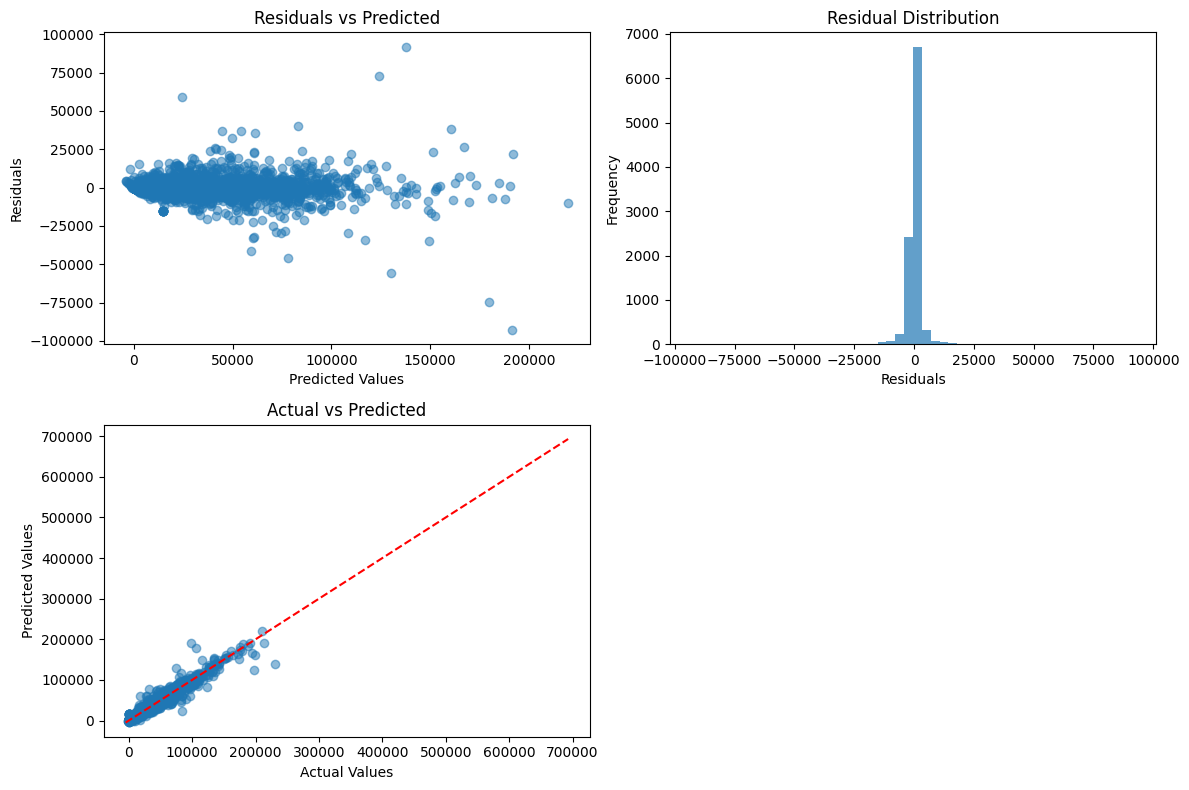

In [36]:
# Block 4: Simple Predictions Fallback
print("Training final Prophet model with best parameters...")

# Train final model on full dataset
final_model = ProphetModel(**best_params)
final_model.fit(processed_train)

# Cross-validation evaluation (on a subset due to computational constraints)
print("Performing cross-validation...")

# Sample some store-dept combinations for CV
sample_combinations = list(final_model.models.keys())[:5]  # Use first 5 for speed

cv_maes = []
for store, dept in sample_combinations:
    if (store, dept) in final_model.models:
        # Get data for this combination
        combo_data = processed_train[(processed_train['Store'] == store) &
                                   (processed_train['Dept'] == dept)]

        if len(combo_data) > 30:  # Only if enough data points
            prophet_data = pd.DataFrame({
                'ds': combo_data['Date'],
                'y': combo_data['Weekly_Sales']
            })

            # Add regressors
            regressors = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
            for col in regressors:
                if col in combo_data.columns:
                    prophet_data[col] = combo_data[col].values

            try:
                model = final_model.models[(store, dept)]
                df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
                df_p = performance_metrics(df_cv)
                cv_maes.append(df_p['mae'].mean())
            except:
                continue

if cv_maes:
    avg_cv_mae = np.mean(cv_maes)
    print(f"Cross-validation MAE: {avg_cv_mae:.2f}")
    wandb.log({'cv_mae': avg_cv_mae})

# Final evaluation metrics
print("Calculating final metrics...")
train_predictions = final_model.predict(processed_train)
train_mae = mean_absolute_error(processed_train['Weekly_Sales'], train_predictions)
train_rmse = np.sqrt(mean_squared_error(processed_train['Weekly_Sales'], train_predictions))

print(f"Final Training MAE: {train_mae:.2f}")
print(f"Final Training RMSE: {train_rmse:.2f}")

# Log final metrics
wandb.log({
    'final_train_mae': train_mae,
    'final_train_rmse': train_rmse,
    'n_models_trained': len(final_model.models)
})

# Create residual plots
sample_idx = np.random.choice(len(train_predictions), min(10000, len(train_predictions)), replace=False)
residuals = processed_train['Weekly_Sales'].iloc[sample_idx] - train_predictions[sample_idx]

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(train_predictions[sample_idx], residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')

plt.subplot(2, 2, 2)
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

plt.subplot(2, 2, 3)
plt.scatter(processed_train['Weekly_Sales'].iloc[sample_idx], train_predictions[sample_idx], alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([processed_train['Weekly_Sales'].min(), processed_train['Weekly_Sales'].max()],
         [processed_train['Weekly_Sales'].min(), processed_train['Weekly_Sales'].max()], 'r--')

plt.tight_layout()
plt.savefig('prophet_evaluation_plots.png', dpi=300, bbox_inches='tight')
wandb.log({"evaluation_plots": wandb.Image('prophet_evaluation_plots.png')})
plt.show()

In [37]:
# Block 5: Save Final SARIMA Pipeline to Wandb
class WalmartProphetPipeline(BaseEstimator):
    def __init__(self, prophet_params=None):
        self.preprocessor = WalmartDataPreprocessor()
        self.prophet_params = prophet_params or best_params
        self.model = None

    def fit(self, X, y=None):
        print("Fitting pipeline...")
        # Preprocess data
        processed_data = self.preprocessor.transform(X, is_train=True)

        # Train Prophet model
        self.model = ProphetModel(**self.prophet_params)
        self.model.fit(processed_data)

        return self

    def predict(self, X):
        if self.model is None:
            raise ValueError("Pipeline must be fitted before making predictions")

        # Preprocess data
        processed_data = self.preprocessor.transform(X, is_train=False)

        # Make predictions
        predictions = self.model.predict(processed_data)

        return predictions

# Create and fit the pipeline
print("Creating Prophet pipeline...")
prophet_pipeline = WalmartProphetPipeline(prophet_params=best_params)
prophet_pipeline.fit(train_df)

# Test pipeline predictions
print("Testing pipeline predictions...")
test_predictions = prophet_pipeline.predict(test_df)

# Create submission
submission_df = sample_submission.copy()
submission_df['Weekly_Sales'] = test_predictions

# Save submission
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
submission_filename = f'prophet_submission_{timestamp}.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"Submission saved as: {submission_filename}")

# Save the pipeline locally first
pipeline_filename = f'prophet_pipeline_{timestamp}.pkl'
joblib.dump(prophet_pipeline, pipeline_filename)
print(f"Pipeline saved locally as: {pipeline_filename}")

# Create WandB Artifact for the model pipeline
print("Creating WandB artifact for the pipeline...")
pipeline_artifact = wandb.Artifact(
    name="prophet_pipeline",
    type="model",
    description="Prophet model pipeline for Walmart sales forecasting",
    metadata={
        "model_type": "Prophet",
        "train_mae": train_mae,
        "train_rmse": train_rmse,
        "n_models": len(final_model.models),
        "best_params": best_params,
        "timestamp": timestamp
    }
)

# Add the pipeline file to the artifact
pipeline_artifact.add_file(pipeline_filename)

# Log the artifact
wandb.log_artifact(pipeline_artifact)

# Also create artifact for submission
submission_artifact = wandb.Artifact(
    name="prophet_submission",
    type="dataset",
    description=f"Prophet model submission for Kaggle - {timestamp}"
)
submission_artifact.add_file(submission_filename)
wandb.log_artifact(submission_artifact)

# Log final summary
wandb.log({
    'pipeline_created': True,
    'pipeline_artifact_name': "prophet_pipeline",
    'submission_artifact_name': "prophet_submission",
    'test_predictions_mean': np.mean(test_predictions),
    'test_predictions_std': np.std(test_predictions),
    'model_registry_success': True
})

print("Prophet experiment completed successfully!")
print("Pipeline and submission saved to WandB artifacts!")
wandb.finish()

Creating Prophet pipeline...
Fitting pipeline...
Training Prophet models for 3331 store-department combinations...
Progress: 0/3331 combinations processed...
Progress: 50/3331 combinations processed...
Progress: 100/3331 combinations processed...
Progress: 150/3331 combinations processed...
Progress: 200/3331 combinations processed...
Progress: 250/3331 combinations processed...
Progress: 300/3331 combinations processed...
Progress: 350/3331 combinations processed...
Progress: 400/3331 combinations processed...
Progress: 450/3331 combinations processed...
Progress: 500/3331 combinations processed...
Progress: 550/3331 combinations processed...
Progress: 600/3331 combinations processed...
Progress: 650/3331 combinations processed...
Progress: 700/3331 combinations processed...
Progress: 750/3331 combinations processed...
Progress: 850/3331 combinations processed...
Progress: 900/3331 combinations processed...
Progress: 950/3331 combinations processed...
Progress: 1000/3331 combinations 

best_mae,▁
cv_mae,▁
final_train_mae,▁
final_train_rmse,▁
hp_set_1_changepoint_prior_scale,▁
hp_set_1_mae,▁
hp_set_1_n_models,▁
hp_set_1_rmse,▁
hp_set_1_seasonality_prior_scale,▁
hp_set_2_changepoint_prior_scale,▁
hp_set_2_mae,▁
